In [32]:
from importlib import reload
import matplotlib.pyplot as plt
import dnd

from dnd import Dice

import pandas as pd
import numpy as np
import json
import os

In [135]:
int("hello")

ValueError: invalid literal for int() with base 10: 'hello'

In [174]:



df.groupby('cr')['ac_val'].mean()

cr
0.000     11.657534
0.125     12.560976
0.250     12.337349
0.500     12.967320
1.000     13.245000
2.000     13.901099
3.000     14.403226
4.000     14.338624
5.000     14.907563
6.000     15.093750
7.000     15.232558
8.000     15.612069
9.000     15.876106
10.000    16.516129
11.000    16.545455
12.000    16.425000
13.000    16.481481
14.000    16.897959
15.000    16.943396
16.000    17.657895
17.000    17.812500
18.000    17.933333
19.000    18.750000
20.000    17.166667
21.000    19.120000
22.000    19.428571
23.000    20.227273
24.000    20.866667
25.000    20.615385
26.000    20.285714
27.000    21.250000
28.000    22.142857
30.000    23.600000
Name: ac_val, dtype: float64

In [169]:
df.groupby('cr')['ac_val'].mean().index[-2]

'1/8'

In [277]:
def read_creatures():
    creatures = []
    path = 'data/bestiary/'
    for filename in os.listdir(path):
        if filename.endswith('.json'):
            with open(path + filename, 'r') as f:
                j = json.load(f)
                if 'monster' in j:
                    for monster_json in j['monster']:
                        is_npc = 'isNpc' in monster_json and monster_json['isNpc']
                        is_copy = '_copy' in monster_json 
                        is_summoned = 'summonedBySpell' in monster_json or 'summonedByClass' in monster_json
                        
                        if not is_npc and not is_copy and not is_summoned:
                            creature = Creature(monster_json)
                            creatures.append(creature)
    return creatures

def flatten_dict(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            try:
                v = float(v)
            except:
                pass
            items.append((new_key, v))
    return dict(items)

def dict_vals_to_float(d):
    return dict( (k, float(v)) for k, v in d.items() )

# turn a list of strings into a dictionary of boolean true values
def list_to_dict(l, sep='_', parent_key=''):
	return {f'{parent_key}{sep}{x}': True for x in l if type(x) == str}

import re
level_regex = re.compile('(\d+)')
fractionlevel_regex = re.compile('(\d+)/(\d+)')
def parse_level(value):
    if type(value) == int or type(value) == float:
        return value
    level_match = level_regex.match(value)
    fraction_match = fractionlevel_regex.match(value)
    if fraction_match:
        
        numerator = float(fraction_match.group(1))
        denominator = float(fraction_match.group(2))
        return numerator / denominator
    if level_match:
        return float(level_match.group(1))
        
    
    return np.nan

class Creature:
    def __init__(self, creature_dict):
        # initialize values from dictionary
        self.creature_dict = creature_dict

    def as_record(self):
        # return a flattened dictionary recursively
        ret = flatten_dict(self.creature_dict)
        if 'cr' in ret:
            ret['cr'] = parse_level(ret['cr'])
        if 'ac' in ret:
            if type(ret['ac'][0]) == dict:
                ret['ac_val'] = ret['ac'][0]['ac']
            elif type(ret['ac'][0]) == int:
                ret['ac_val'] = ret['ac'][0]
        if 'immune' in ret:
            ret.update(list_to_dict(ret['immune'], parent_key='immune'))
        if 'resist' in ret:
            resist_ret = list_to_dict(ret['resist'], parent_key='resist')
            if 'resist' in ret:
                for v in ret['resist']:
                    if type(v) == dict and 'resist' in v:
                        resist_ret.update(list_to_dict(v['resist'], parent_key='resist'))
            ret.update(resist_ret)
        if 'conditionImmune' in ret:
            ret.update(list_to_dict(ret['conditionImmune'], parent_key='conditionImmune'))
        return ret
    

attributes = ['cha', 'con', 'dex', 'int', 'str', 'wis']
skll_to_attributes = {
    'acrobatics': 'dex',
    'animal handling': 'wis',
    'arcana': 'int',
    'athletics': 'str',
    'deception': 'cha',
    'history': 'int',
    'insight': 'wis',
    'intimidation': 'cha',
    'investigation': 'int',
    'medicine': 'wis',
    'nature': 'int',
    'perception': 'wis',
    'performance': 'cha',
    'persuasion': 'cha',
    'religion': 'int',
    'sleight of hand': 'dex',
    'stealth': 'dex',
    'survival': 'wis'
}

def fill_columnset_default(df, column_prefix, default):
    for column in df.columns:
        if column.startswith(column_prefix):
            df[column] = df[column].fillna(default)
    return df

def get_creatures_df():
    creatures = read_creatures()
    creatures_df = pd.DataFrame([c.as_record() for c in creatures])
    creatures_df = creatures_df[creatures_df['cr'].isna() == False].reset_index(drop=True)
    for attribute in attributes:
        creatures_df['save_'+attribute] = np.where(
            creatures_df['save_'+attribute] > np.round((creatures_df[attribute] - 10)/2), 
            creatures_df[attribute], 
            np.round((creatures_df[attribute] - 10)/2)
        )

    for skill in skll_to_attributes:
        creatures_df['skill_'+skill] = np.where(
            creatures_df['skill_'+skill] > np.round((creatures_df[skll_to_attributes[skill]] - 10)/2), 
            creatures_df[skll_to_attributes[skill]], 
            np.round((creatures_df[skll_to_attributes[skill]] - 10)/2)
        )

    for col in ['immune', 'conditionImmune', 'resist', 'vulnerable']:
        fill_columnset_default(creatures_df, col+'_', False)
    

    return creatures_df

In [292]:
creatures = get_creatures_df()
#creatures = creatures[creatures.source=='MM'].reset_index(drop=True)
@quit

<Axes: xlabel='cr'>

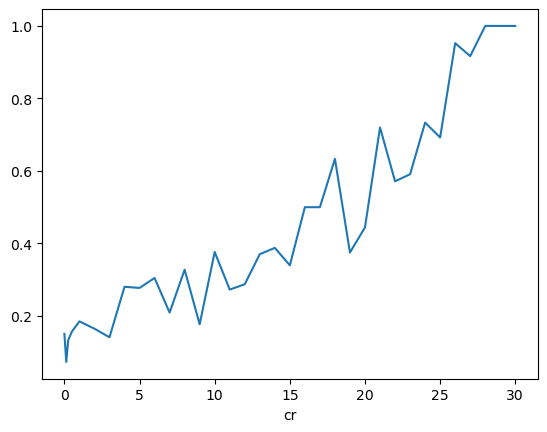

In [293]:
creatures.groupby('cr').conditionImmune_charmed.mean().plot()

Text(0.5, 1.0, 'Save failure rate by CR of creatures affected by spell\n adjusted for condition immunities and character level\n(CR 10 monster facing CR 10 player)')

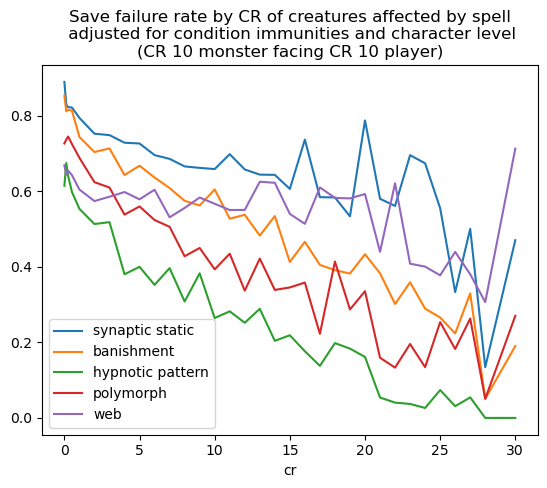

In [287]:
save_dc = lambda c: 5+dnd.proficency_bonus(min(max(c['cr'],1), 20))+8

res = []
for c in creatures.iterrows():
    c = c[1]
    r = creature_condition_save(c, 'int', save_dc(c), 'banished')
    res.append(r)
pd.concat([creatures[['cr']], pd.Series(res, name='damage')], axis=1).groupby('cr').damage.mean().plot(label='synaptic static')

res = []
for c in creatures.iterrows():
    c = c[1]
    r = creature_condition_save(c, 'cha', save_dc(c), 'banished')
    res.append(r)
pd.concat([creatures[['cr']], pd.Series(res, name='damage')], axis=1).groupby('cr').damage.mean().plot(label='banishment')



res = []
for c in creatures.iterrows():
    c = c[1]
    r = creature_condition_save(c, 'wis', save_dc(c), 'charmed')
    res.append(r)
pd.concat([creatures[['cr']], pd.Series(res, name='damage')], axis=1).groupby('cr').damage.mean().plot(label='hypnotic pattern')


res = []
for c in creatures.iterrows():
    c = c[1]
    r = creature_condition_save(c, 'wis', save_dc(c), 'polymorphed')
    res.append(r)
pd.concat([creatures[['cr']], pd.Series(res, name='damage')], axis=1).groupby('cr').damage.mean().plot(label='polymorph')



res = []
for c in creatures.iterrows():
    c = c[1]
    r = creature_condition_save(c, 'dex', save_dc(c), 'restrianed')
    res.append(r)
pd.concat([creatures[['cr']], pd.Series(res, name='damage')], axis=1).groupby('cr').damage.mean().plot(label='web')



plt.legend()
plt.title('Save failure rate by CR of creatures affected by spell\n adjusted for condition immunities and character level\n(CR 10 monster facing CR 10 player)')

In [255]:
creatures_df.source.value_counts().index

Index(['MM', 'ToB1-2023', 'MPMM', 'MTF', 'VGM', 'GHLoE', 'FTD', 'GGR', 'BAM',
       'BGG', 'MaBJoV', 'MPP', 'MOT', 'SCC', 'TDCSR', 'HWCS', 'GoS', 'ERLW',
       'BMT', 'IDRotF', 'VRGR', 'CoA', 'ToA', 'VEoR', 'QftIS', 'EGW', 'MCV4EC',
       'DoDk', 'CRCotN', 'PaBTSO', 'CM', 'OotA', 'TftYP', 'PotA', 'WBtW',
       'MFF', 'DSotDQ', 'BGDIA', 'WDH', 'MCV2DC', 'JttRC', 'MCV1SC', 'SKT',
       'WDMM', 'TCE', 'CoS', 'AI', 'HAT-TG', 'MisMV1', 'MGELFT', 'AWM', 'SLW',
       'MCV3MC', 'PSX', 'IMR', 'SDW', 'PHB', 'TTP', 'DoSI', 'PSI', 'HoL',
       'HotDQ', 'DC', 'LMoP', 'ESK', 'PSD', 'PSK', 'LLK', 'HftT', 'DMG',
       'AATM', 'PSZ', 'RoT', 'PSA', 'DIP', 'AitFR-DN', 'KftGV', 'AitFR-THP',
       'NRH-AVitW', 'AitFR-FCD', 'VD', 'LoX', 'KKW', 'NRH-ASS', 'RtG', 'SADS',
       'NRH-CoI', 'XGE', 'DoD', 'LR', 'NRH-TCMC', 'DitLCoT'],
      dtype='object', name='source')